In [ ]:
###
# @Author             : Monserrat López
# @Date               : 2025-03-18
# @Last Modified Date : 2025-04-27
# @Description        : Estimation of CO₂ emissions from European data centers based on area-driven 
#                       energy consumption models and Electricity Maps carbon intensity data. 
#                       Includes spatial joins, manual corrections, and emission aggregations.
# @Note               : This script is intended for academic research purposes only.
#                       Some original raw data collected during the research is not included in this repository for confidentiality reasons.
###

In [2]:
# Imports
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import glob
from shapely.geometry import shape


In [3]:
# Set the visualization style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

### Compute average Carbon Intensities from Electricity Maps

In [4]:
# Set the path to your folder with the CSVs

# Collect all 2024 hourly CSVs
csv_files = glob.glob(os.path.join("../input/ElectricityData/ElectricityMaps/EU_data", "*_2024_hourly.csv"))

summary = []

for file_path in csv_files:
    try:
        # Extract zone code from filename
        filename = os.path.basename(file_path)
        zone = filename.split("_")[0]

        # Load CSV and select the right column
        df = pd.read_csv(file_path)

        # Use the LCA-based carbon intensity column
        intensity_col = "Carbon intensity gCO₂eq/kWh (Life cycle)"
        if intensity_col not in df.columns:
            raise KeyError(f"{intensity_col} not found in {filename}")

        avg_intensity = df[intensity_col].mean()
        n_hours = len(df)

        summary.append({
            "zone": zone,
            "avg_carbon_intensity_gco2_kwh": round(avg_intensity, 2),
            "n_hours": n_hours
        })

    except Exception as e:
        print(f"Failed for {file_path}: {e}")

# Save to CSV
df_summary = pd.DataFrame(summary)
df_summary.to_csv("../output/11_electricity_maps_2024_averages.csv", index=False)

print(f"\nSaved average intensities for {len(df_summary)} zones.")


Saved average intensities for 38 zones.


In [6]:
# Calculate the simple mean
eu27_avg_intensity = df_summary["avg_carbon_intensity_gco2_kwh"].mean()
eu27_avg_intensity

245.55394736842098

### Load GeoJSON geometries for bidding zones

In [4]:
### Geo filed was obtained from https://github.com/electricitymaps/zone-finder 

In [5]:
with open("../input/ElectricityData/ElectricityMaps/geo.generated.json", "r") as f:
    raw = json.load(f)

features = raw["convexhulls"]
records = []
for feature in features:
    geom = shape(feature["geometry"])
    props = feature.get("properties", {})
    props["geometry"] = geom
    records.append(props)

gdf_zones = gpd.GeoDataFrame(records, crs="EPSG:4326").dissolve(by="zoneName", as_index=False)

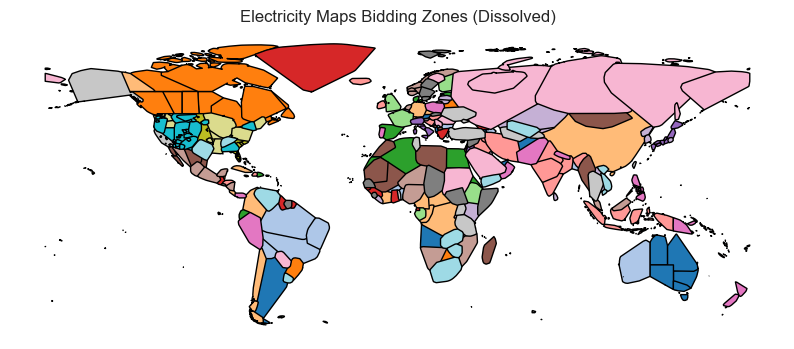

In [6]:
gdf_zones.plot(column="zoneName", cmap="tab20", figsize=(10, 10), edgecolor="black")
plt.title("Electricity Maps Bidding Zones (Dissolved)")
plt.axis("off")
plt.show()

In [7]:
# Load and prepare data center dataset
df_dc = pd.read_csv("../output/10_EC_DC_EU27.csv")
df_dc["dc_id"] = df_dc.index
gdf_dc = gpd.GeoDataFrame(df_dc, geometry=gpd.points_from_xy(df_dc.longitude, df_dc.latitude), crs="EPSG:4326")

In [8]:
# Merge bidding zones with carbon intensity
ci_df = df_summary.rename(columns={"zone": "zoneName"})
gdf_zones = gdf_zones.merge(ci_df, on="zoneName", how="left")

In [9]:
# Spatial join — assign bidding zones to data centers
gdf_dc_zones = gpd.sjoin(gdf_dc, gdf_zones, how="left", predicate="within")

In [10]:
# Analyse duplications
duplicates = gdf_dc_zones[gdf_dc_zones.duplicated(subset=["url"], keep=False)]
print(f"Potential duplicates from join: {len(duplicates)}")

Potential duplicates from join: 303


In [11]:
# De-duplicate based on country-zone match
gdf_dc_zones["zone_match"] = gdf_dc_zones["zoneName"].str[:2] == gdf_dc_zones["country_iso2"]
gdf_dc_zones = (
    gdf_dc_zones
    .sort_values(by="zone_match", ascending=False)
    .drop_duplicates(subset=["url"], keep="first")
    .drop(columns=["zone_match"])
)

In [12]:
# Handle unmatched zones (islands, missing regions)
fallback_map = {
    "ES-IB-MA": "ES", "ES-IB-IZ": "ES", "ES-CN-TE": "ES", "ES-CN-LP": "ES",
    "MT": "MT", "EE": "EE", "NL": "NL"
}
gdf_dc_zones["zoneName"] = gdf_dc_zones["zoneName"].replace(fallback_map)

In [13]:
# Re-merge to update carbon intensity
gdf_dc_zones = gdf_dc_zones.drop(columns="avg_carbon_intensity_gco2_kwh", errors="ignore")
gdf_dc_zones = gdf_dc_zones.merge(ci_df, on="zoneName", how="left")

In [14]:
print("Missing zone assignments:", gdf_dc_zones["zoneName"].isna().sum())
print("Missing carbon intensity:", gdf_dc_zones["avg_carbon_intensity_gco2_kwh"].isna().sum())

Missing zone assignments: 5
Missing carbon intensity: 6


In [15]:
print("Missing zone assignments:", gdf_dc_zones["zoneName"].isna().sum())
print("Missing carbon intensity:", gdf_dc_zones["avg_carbon_intensity_gco2_kwh"].isna().sum())

# Optional: export or inspect
unmatched = gdf_dc_zones[gdf_dc_zones["avg_carbon_intensity_gco2_kwh"].isna()]
print(unmatched[["datacentername", "latitude", "longitude", "country_iso2", "zoneName"]])


Missing zone assignments: 5
Missing carbon intensity: 6
                    datacentername   latitude  longitude country_iso2 zoneName
1592              narva-datacenter  59.361447  28.192028           EE     RU-1
1593                        melita  35.922823  14.467367           MT      NaN
1595                        d-alix  28.083833 -16.503103           ES      NaN
1596              google_eemshaven  53.424266   6.859006           NL      NaN
1597         aire-oasix-las-palmas  28.148879 -15.426680           ES      NaN
1599  civicos-networking-lanzarote  28.964806 -13.552097           ES      NaN


In [16]:
## Manual Zone Assignment
# Patch missing zone names manually
manual_zones = {
    1592: "EE",  # Narva is in Estonia
    1593: "MT",  # Malta
    1595: "ES",  # Tenerife (Spain)
    1596: "NL",  # Netherlands coast
    1597: "ES",  # Las Palmas, Canary Islands
    1599: "ES",  # Lanzarote, Canary Islands
}

for idx, zone in manual_zones.items():
    gdf_dc_zones.loc[idx, "zoneName"] = zone

In [17]:
# Reduce ci_df to just the two needed columns
ci_df_clean = ci_df[["zoneName", "avg_carbon_intensity_gco2_kwh"]]

# Drop old carbon intensity column and re-merge cleanly
gdf_dc_zones = gdf_dc_zones.drop(columns=["avg_carbon_intensity_gco2_kwh"], errors="ignore")
gdf_dc_zones = gdf_dc_zones.merge(ci_df_clean, on="zoneName", how="left")

# Optional check
print("Remaining missing carbon intensity values:", gdf_dc_zones["avg_carbon_intensity_gco2_kwh"].isna().sum())

Remaining missing carbon intensity values: 0


### Emissions calculation (from TWh × gCO₂/kWh → tons CO₂)

In [18]:
# Emissions calculation (in tons CO₂/year)
for scenario in ["low", "mid", "high"]:
    gdf_dc_zones[f"emissions_{scenario}_tons"] = (
        gdf_dc_zones[f"energy_{scenario}_twh"] * gdf_dc_zones["avg_carbon_intensity_gco2_kwh"] * 1_000
    )

# Aggregate emissions by country
country_emissions = gdf_dc_zones.groupby("country_iso2").agg(
    total_emissions_low_tons=("emissions_low_tons", "sum"),
    total_emissions_mid_tons=("emissions_mid_tons", "sum"),
    total_emissions_high_tons=("emissions_high_tons", "sum"),
    number_of_dcs=("datacentername", "count")
).reset_index()

# Calculate total emissions EU-wide (in Mt CO₂/year)
# Formula: emissions (tons) = TWh × gCO₂/kWh × 1,000
total_emissions = {
    scenario: gdf_dc_zones[f"emissions_{scenario}_tons"].sum() / 1_000_000
    for scenario in ["low", "mid", "high"]
}

# Save outputs
gdf_dc_zones.to_file("../output/12_data_center_emissions.geojson", driver="GeoJSON")

In [19]:
country_emissions

,country_iso2,total_emissions_low_tons,total_emissions_mid_tons,total_emissions_high_tons,number_of_dcs
0,AT,1.025753e+05,1.165069e+05,1.304384e+05,41
1,BE,9.922589e+04,1.108521e+05,1.224782e+05,37
2,BG,1.067384e+05,1.201646e+05,1.335908e+05,23
3,CY,3.816668e+05,4.345042e+05,4.873415e+05,11
4,CZ,2.040205e+05,2.307945e+05,2.575685e+05,36
5,DE,5.317890e+06,6.007514e+06,6.697138e+06,341
6,DK,2.171752e+05,2.271006e+05,2.370261e+05,43
7,EE,3.298619e+04,3.731300e+04,4.163982e+04,8
8,ES,3.616696e+05,3.995059e+05,4.373422e+05,111
9,FI,6.373673e+04,7.171492e+04,7.969311e+04,31


In [20]:
total_emissions

{'low': 14.165342340424202,
 'mid': 15.665055763782483,
 'high': 17.164769187140717}

In [21]:
# Export CO₂ data per data center (with geometry) to GeoJSON
gdf_dc_zones.to_file("../output/12_data_center_emissions.geojson", driver="GeoJSON")

In [22]:
#Total EU-wide emissions
total_emissions_mid = gdf_dc_zones["emissions_mid_tons"].sum()
total_emissions_low = gdf_dc_zones["emissions_low_tons"].sum()
total_emissions_high = gdf_dc_zones["emissions_high_tons"].sum()

print(f"Total EU data center emissions (mid):  {total_emissions_mid:,.0f} tons CO₂e/year")
print(f"Total EU data center emissions (low):  {total_emissions_low:,.0f} tons CO₂e/year")
print(f"Total EU data center emissions (high): {total_emissions_high:,.0f} tons CO₂e/year")

Total EU data center emissions (mid):  15,665,056 tons CO₂e/year
Total EU data center emissions (low):  14,165,342 tons CO₂e/year
Total EU data center emissions (high): 17,164,769 tons CO₂e/year


In [23]:
# Total EU-wide emissions in tons CO₂/year
total_emissions_mid = gdf_dc_zones["emissions_mid_tons"].sum()
total_emissions_low = gdf_dc_zones["emissions_low_tons"].sum()
total_emissions_high = gdf_dc_zones["emissions_high_tons"].sum()

# Convert to Mt CO₂/year
total_emissions_mid_mt = total_emissions_mid / 1_000_000
total_emissions_low_mt = total_emissions_low / 1_000_000
total_emissions_high_mt = total_emissions_high / 1_000_000

# Print results
print(f"Total EU data center emissions (mid):  {total_emissions_mid_mt:.2f} Mt CO₂e/year")
print(f"Total EU data center emissions (low):  {total_emissions_low_mt:.2f} Mt CO₂e/year")
print(f"Total EU data center emissions (high): {total_emissions_high_mt:.2f} Mt CO₂e/year")

Total EU data center emissions (mid):  15.67 Mt CO₂e/year
Total EU data center emissions (low):  14.17 Mt CO₂e/year
Total EU data center emissions (high): 17.16 Mt CO₂e/year
